# Transfer Learning

In this exercice we will use a **pre-trained convnet** as a feature extractor. \
We will **finetune the convnet** to solve a classification problem

This notebooks is heavily inpired by : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Packages

In [1]:
import copy
import os
import sys
import time
from torchsummary import summary

import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import CIFAR100 
from torchvision.transforms import Compose, ToTensor, Resize, ToPILImage
from torch.utils.data import DataLoader, ConcatDataset

## Prepare PyTorch device

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(device)
print(f"Running notebook on {device_name}")

Running notebook on NVIDIA GeForce RTX 3060 Ti


## CIFAR-100 Dataset

Download the cifar-100 dataset

In [3]:
# Load dataset
dataset = CIFAR100("_downloaded", train=True, download=True, transform=Compose([ToTensor(), Resize((224,224))]))
num_samples = len(dataset)
num_train = int(num_samples * 0.7)
num_valid = int(num_samples * 0.2)
num_test = num_samples - num_valid - num_train
lengths = [num_train, num_valid, num_test]

# Split data into train/valid/test dataset
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths)

dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['val'] = len(valid_dataset)
dataset_sizes['test'] = len(test_dataset)

# Train Dataloader
dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=8)

# Valid Dataloader
dataloaders['val'] = DataLoader(valid_dataset,
                                  batch_size=32,
                                  shuffle=False,
                                  num_workers=8)

# Test Dataloader
dataloaders['test'] = DataLoader(test_dataset,
                                 batch_size=32,
                                 shuffle=False,
                                 num_workers=8)

# Statistics
print("training examples : ", dataset_sizes['train'])
print("validation examples : ", dataset_sizes['val'])
print("test examples :", dataset_sizes['test'])

Files already downloaded and verified
training examples :  35000
validation examples :  10000
test examples : 5000


## Visualize input (labels + images)

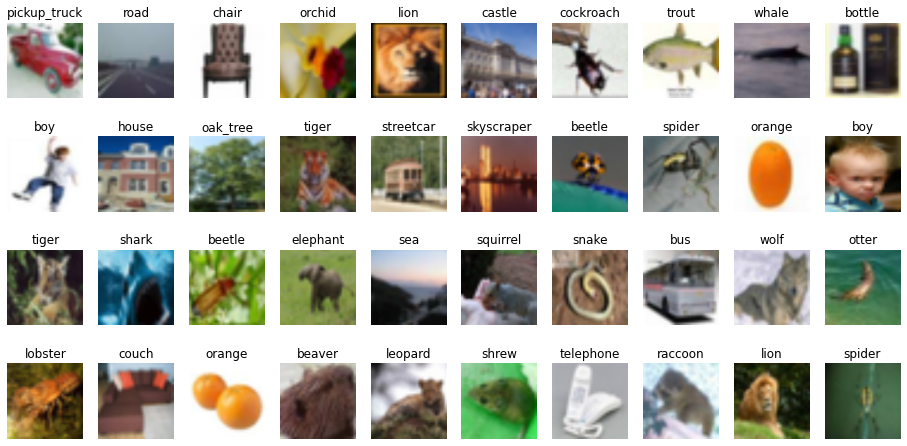

In [4]:
category_names = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 
                  'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 
                  'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 
                  'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 
                  'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 
                  'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 
                  'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 
                  'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 
                  'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 
                  'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 
                  'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

def show(data, cols = 10, rows = 4):
    figure = plt.figure(figsize=(16, 8))
    to_PIL = ToPILImage()
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = data[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(category_names[label])
        plt.axis("off")
        plt.imshow(to_PIL(img), cmap="gray")
    plt.show()

show(train_dataset, cols = 10, rows = 4)

## Pre-trained ConvNet (ResNet18) as a fixed feature extractor

Use ResNet18 [https://arxiv.org/abs/1512.03385] has a base
The output 

In [5]:
# Load pre-trained CNN model
model_conv = torchvision.models.resnet18(pretrained=True)
#print(model_conv) # Uncomment to visualize the model layers

# Disable the gradient computation for all the network
for param in model_conv.parameters():
    param.requires_grad = False

# Replace the last layer (model_conv.fc) to match our categories (from ImageNet with 1000 categories to CIFAR 100)
num_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_features, len(category_names))
model_conv.fc.requires_grad = True

# Print the number of trainable parameters
trainable_parameters = sum(p.numel() for p in model_conv.parameters() if p.requires_grad)
print(f"{trainable_parameters} trainable parameters")

# summarize the layer
summary(model_conv.cuda(), (3, 224, 224))

51300 trainable parameters
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
            

## Optimize ConvNet

In [6]:
# Code from : https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# This code is a standard pytorch training loop and unrelated to the transfer learning logic
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_since = time.time()
        print('-' * 10)
        print(f'Epoch start {epoch}/{num_epochs - 1}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        time_elapsed = time.time() - epoch_since
        print(f'Epoch end {epoch}/{num_epochs - 1} in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Define the model, criterion and optimizer

In [7]:
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Run the training (**be patient** ! It took 11m 18s on **NVIDIA GeForce RTX 3060 Ti**)

In [8]:
model_conv = train_model(model_conv, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

----------
Epoch start 0/9
train Loss: 3.4476 Acc: 0.2704
val Loss: 2.5844 Acc: 0.4257
Epoch end 0/9 in 0m 53s
----------
Epoch start 1/9
train Loss: 2.3389 Acc: 0.4716
val Loss: 2.0677 Acc: 0.5029
Epoch end 1/9 in 0m 54s
----------
Epoch start 2/9
train Loss: 1.9928 Acc: 0.5199
val Loss: 1.8691 Acc: 0.5243
Epoch end 2/9 in 0m 54s
----------
Epoch start 3/9
train Loss: 1.8303 Acc: 0.5417
val Loss: 1.7556 Acc: 0.5424
Epoch end 3/9 in 0m 54s
----------
Epoch start 4/9
train Loss: 1.7238 Acc: 0.5591
val Loss: 1.6958 Acc: 0.5516
Epoch end 4/9 in 0m 53s
----------
Epoch start 5/9
train Loss: 1.6493 Acc: 0.5740
val Loss: 1.6599 Acc: 0.5540
Epoch end 5/9 in 0m 53s
----------
Epoch start 6/9
train Loss: 1.5955 Acc: 0.5808
val Loss: 1.6147 Acc: 0.5636
Epoch end 6/9 in 0m 53s
----------
Epoch start 7/9
train Loss: 1.5360 Acc: 0.5985
val Loss: 1.6011 Acc: 0.5658
Epoch end 7/9 in 0m 53s
----------
Epoch start 8/9
train Loss: 1.5353 Acc: 0.5963
val Loss: 1.5955 Acc: 0.5693
Epoch end 8/9 in 0m 54s
-

## Save model

In [9]:
torch.save(model_conv, "best.pth")

## Load model

In [10]:
model_conv = torch.load("best.pth")
model_conv.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Test loaded model (TODO)

In [ ]:
# TODO - Write code to use dataloaders['test'] from model_conv

## Exploration (TODO)

Experimentations in Machine Learning is essential. For this part you will experiment by trying :
- different CNN models (ResNet, MobileNets, etc.)
- different hyperparameters (batch size, learning rate, etc.)
- different transfer (we are using the last layer, what about keeping the first few conv ? )

You will report your result to the ML Group